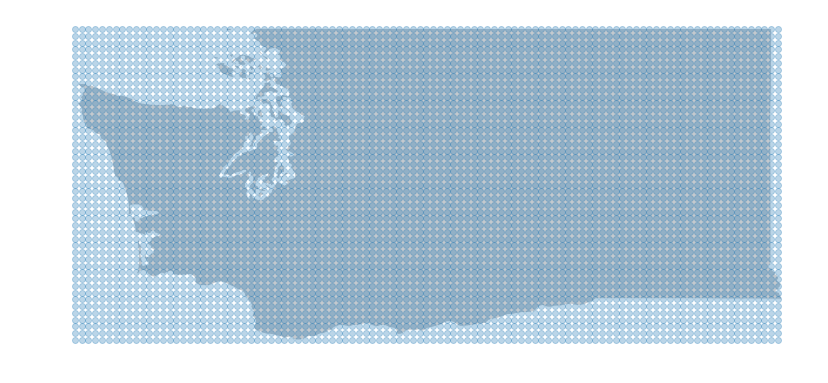

In [1]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame
from shapely.geometry import Polygon
import matplotlib as mpl

%matplotlib inline 
mpl.rcParams['figure.figsize'] = (14,14)

nan = 'np.nan'
bing_api_key = ''
crs = {'init': 'epsg:4326'}

shp = 'Shapes/States/cb_2017_us_state_500k.shp'
us = gpd.read_file(shp)
wa = us[us['STUSPS']=="WA"]
by = .075    #trying a slightly larger grid to keep from crashing everything.


pts_grid = (
    pd.concat([pd.DataFrame({'pts_lon' : np.arange(wa.bounds['minx'], wa.bounds['maxx'], by)})
               , (pd.DataFrame({'pts_lat' : np.arange(wa.bounds['miny'], wa.bounds['maxy'], by)})
                  .pivot(columns = 'pts_lat', values = 'pts_lat'))]
        , axis = 1
             )
    .replace(method='ffill')
    .replace(method='bfill')
    .melt(id_vars=['pts_lon'])
    .drop('variable', 1)
    .rename(columns = {'value' : 'pts_lat'})
    .reset_index()
    .rename(columns={"index": "point_id"})
)
geometry_pts = [Point(xy) for xy in zip(pts_grid.pts_lon, pts_grid.pts_lat)]
gdf_pts_grid = GeoDataFrame(pts_grid, crs=crs, geometry=geometry_pts)

wa_plot = wa.plot(color='#C4C9CE', edgecolor='white')

(    gdf_pts_grid
        .plot(ax=wa_plot, alpha = .3)
        .set_axis_off())



#save to shapefile so I can clip them in QGIS
#gdf_pts_grid.to_file("WA_01grid.shp")
#gdf_pts_grid

This block is just to see how the points look when plotted, so I can double-check that I clipped them right in QGIS:

In [2]:
%matplotlib inline 
mpl.rcParams['figure.figsize'] = (14,14)

pts = 'WA_01pts.shp'
wa_pt_grid = gpd.read_file(pts)

wa_pt_grid.plot(alpha = .1)



OSError: no such file or directory: 'WA_01pts.shp'

In [3]:
from itertools import combinations
from random import randint
import json
from requests.exceptions import HTTPError
from urllib.error import URLError
import simplejson
import urllib
from datetime import datetime
from decimal import Decimal

file = 'Shapes/09/CD09_01pts.shp'
CDgrid = gpd.read_file(file)

#zip lat/long to single column (easier than dealing with shapely geometry)
CDgrid['lat,long'] = list(zip(CDgrid.pts_lat, CDgrid.pts_lon))

#create a list of all coordinates so I can write this to NxN matrix
xytups = CDgrid['lat,long'].tolist()

#find all unique combinations of list entries, removes duplicate geocoding (assuming travel time from A to B = B to A.)
unicombos = [comb for comb in combinations(xytups, 2)]  

#these next lines let me see what I'm up against, computationally - for CD09_05pts, I get 27 points, 351 unique combinations, and 729 possible combinations to work with.
#pointcount = len(xytups)
#totalcombinations = len(xytups)*len(xytups)
#print(pointcount)
#print(len(unicombos)) 
#print(totalcombinations)
   
#create the similarity matrix of n by n points
#dmatrix = pd.DataFrame(index = xytups, columns = xytups)
dmatrix = pd.read_pickle('Shapes/09/CD09_01dmx.pkl')

#now, use the Bing API to populate the matrix. I need to use indexing to extract the data I need since I a tuple within a tuple.
# For example, str(unicombos[0][0][0])) selects the first unique combination, then the first point in the combo, then the first coordinate in that point: ((a,b),(c,d)) becomes 'a'.
length = len(unicombos)
key =''

print(length)



199396


In [29]:
totalcells = len(xytups)*len(xytups)
print(totalcells)

dcount = dmatrix.describe()

dcount.sum(axis=1)




399424


count      399423
unique     349500
top       1041904
freq         2239
dtype: int64

In [30]:
dmatrix.to_pickle('Shapes/09/CD09_01dmx.pkl')

In [28]:
#need to calculate in sets of 50k per day.
#if failure message, save matrix. Find total count, and begin range at that number.
#save after each failure, but do not run the definition cell again or it will overwrite.
#then run the for loop again without running


#UTC Time = 7 hours ahead of Pacific.
#7/15/2018 11:41 0-30,001
#8 PM 30,000 to 50,000
#7/16/18
#6:15 PM 50,000 to 80,000
#10:30 80,000 to 100,000
#7/17/18
#8:00 PM 100,000 to 125,000
#7/18/18
#7:00 am 125,000 to 150,000
#8:30 pm 150,000 to 175,001
#7/19/18
#7:10 AM 175,000 to 199,397

for i in range(175000, 199397):
    #select the target coordinate pairs in each unique tuple (origin, destination)
    origtup = unicombos[i][0]
    desttup = unicombos[i][1]
    
    #select the x and y coordinates for each of the pairs in the unique tuple
    origx = unicombos[i][0][0]
    origy = unicombos[i][0][1]    
    destx = unicombos[i][1][0]
    desty = unicombos[i][1][1]
     
    #cast coordinates to string for the REST API    
    strox = str(origx)
    stroy = str(origy)
    strdx = str(destx)
    strdy = str(desty)
    
    #calculate travel time
    #ttime = randint(1000,9999)
    try:
        url = 'http://dev.virtualearth.net/REST/V1/Routes/Driving?wp.0=' + strox + ',' + stroy + '&wp.1=' + strdx + ',' + strdy + '&key=' + key
        request = urllib.request.Request(url)
        response = urllib.request.urlopen(request)
    except HTTPError:
        ttime = Decimal('nan')
    except URLError:
        ttime = Decimal('nan')
    else:
        r = response.read().decode(encoding="utf-8")
        result = json.loads(r)
        ttime = (result["resourceSets"][0]["resources"][0]["travelDurationTraffic"])
    
    #populate the matrix
    dmatrix.loc[origtup, desttup]= ttime
    dmatrix.loc[desttup, origtup]= ttime
    dmatrix.loc[origtup, origtup]= 0 #setting travel time between identical points to 0, but MDS doesn't like zeros. This is easy to replace, just need to figure out what to replace with.
    print(i)
        
dmatrix.loc[desttup, desttup] = 0 #I added this after, to try and catch the last NaN
dmatrix.to_pickle('Shapes/09/CD09_01dmx.pkl')


175000
175001
175002
175003
175004
175005
175006
175007
175008
175009
175010
175011
175012
175013
175014
175015
175016
175017
175018
175019
175020
175021
175022
175023
175024
175025
175026
175027
175028
175029
175030
175031
175032
175033
175034
175035
175036
175037
175038
175039
175040
175041
175042
175043
175044
175045
175046
175047
175048
175049
175050
175051
175052
175053
175054
175055
175056
175057
175058
175059
175060
175061
175062
175063
175064
175065
175066
175067
175068
175069
175070
175071
175072
175073
175074
175075
175076
175077
175078
175079
175080
175081
175082
175083
175084
175085
175086
175087
175088
175089
175090
175091
175092
175093
175094
175095
175096
175097
175098
175099
175100
175101
175102
175103
175104
175105
175106
175107
175108
175109
175110
175111
175112
175113
175114
175115
175116
175117
175118
175119
175120
175121
175122
175123
175124
175125
175126
175127
175128
175129
175130
175131
175132
175133
175134
175135
175136
175137
175138
175139
175140
175141
175142

176171
176172
176173
176174
176175
176176
176177
176178
176179
176180
176181
176182
176183
176184
176185
176186
176187
176188
176189
176190
176191
176192
176193
176194
176195
176196
176197
176198
176199
176200
176201
176202
176203
176204
176205
176206
176207
176208
176209
176210
176211
176212
176213
176214
176215
176216
176217
176218
176219
176220
176221
176222
176223
176224
176225
176226
176227
176228
176229
176230
176231
176232
176233
176234
176235
176236
176237
176238
176239
176240
176241
176242
176243
176244
176245
176246
176247
176248
176249
176250
176251
176252
176253
176254
176255
176256
176257
176258
176259
176260
176261
176262
176263
176264
176265
176266
176267
176268
176269
176270
176271
176272
176273
176274
176275
176276
176277
176278
176279
176280
176281
176282
176283
176284
176285
176286
176287
176288
176289
176290
176291
176292
176293
176294
176295
176296
176297
176298
176299
176300
176301
176302
176303
176304
176305
176306
176307
176308
176309
176310
176311
176312
176313

177342
177343
177344
177345
177346
177347
177348
177349
177350
177351
177352
177353
177354
177355
177356
177357
177358
177359
177360
177361
177362
177363
177364
177365
177366
177367
177368
177369
177370
177371
177372
177373
177374
177375
177376
177377
177378
177379
177380
177381
177382
177383
177384
177385
177386
177387
177388
177389
177390
177391
177392
177393
177394
177395
177396
177397
177398
177399
177400
177401
177402
177403
177404
177405
177406
177407
177408
177409
177410
177411
177412
177413
177414
177415
177416
177417
177418
177419
177420
177421
177422
177423
177424
177425
177426
177427
177428
177429
177430
177431
177432
177433
177434
177435
177436
177437
177438
177439
177440
177441
177442
177443
177444
177445
177446
177447
177448
177449
177450
177451
177452
177453
177454
177455
177456
177457
177458
177459
177460
177461
177462
177463
177464
177465
177466
177467
177468
177469
177470
177471
177472
177473
177474
177475
177476
177477
177478
177479
177480
177481
177482
177483
177484

178513
178514
178515
178516
178517
178518
178519
178520
178521
178522
178523
178524
178525
178526
178527
178528
178529
178530
178531
178532
178533
178534
178535
178536
178537
178538
178539
178540
178541
178542
178543
178544
178545
178546
178547
178548
178549
178550
178551
178552
178553
178554
178555
178556
178557
178558
178559
178560
178561
178562
178563
178564
178565
178566
178567
178568
178569
178570
178571
178572
178573
178574
178575
178576
178577
178578
178579
178580
178581
178582
178583
178584
178585
178586
178587
178588
178589
178590
178591
178592
178593
178594
178595
178596
178597
178598
178599
178600
178601
178602
178603
178604
178605
178606
178607
178608
178609
178610
178611
178612
178613
178614
178615
178616
178617
178618
178619
178620
178621
178622
178623
178624
178625
178626
178627
178628
178629
178630
178631
178632
178633
178634
178635
178636
178637
178638
178639
178640
178641
178642
178643
178644
178645
178646
178647
178648
178649
178650
178651
178652
178653
178654
178655

179684
179685
179686
179687
179688
179689
179690
179691
179692
179693
179694
179695
179696
179697
179698
179699
179700
179701
179702
179703
179704
179705
179706
179707
179708
179709
179710
179711
179712
179713
179714
179715
179716
179717
179718
179719
179720
179721
179722
179723
179724
179725
179726
179727
179728
179729
179730
179731
179732
179733
179734
179735
179736
179737
179738
179739
179740
179741
179742
179743
179744
179745
179746
179747
179748
179749
179750
179751
179752
179753
179754
179755
179756
179757
179758
179759
179760
179761
179762
179763
179764
179765
179766
179767
179768
179769
179770
179771
179772
179773
179774
179775
179776
179777
179778
179779
179780
179781
179782
179783
179784
179785
179786
179787
179788
179789
179790
179791
179792
179793
179794
179795
179796
179797
179798
179799
179800
179801
179802
179803
179804
179805
179806
179807
179808
179809
179810
179811
179812
179813
179814
179815
179816
179817
179818
179819
179820
179821
179822
179823
179824
179825
179826

180855
180856
180857
180858
180859
180860
180861
180862
180863
180864
180865
180866
180867
180868
180869
180870
180871
180872
180873
180874
180875
180876
180877
180878
180879
180880
180881
180882
180883
180884
180885
180886
180887
180888
180889
180890
180891
180892
180893
180894
180895
180896
180897
180898
180899
180900
180901
180902
180903
180904
180905
180906
180907
180908
180909
180910
180911
180912
180913
180914
180915
180916
180917
180918
180919
180920
180921
180922
180923
180924
180925
180926
180927
180928
180929
180930
180931
180932
180933
180934
180935
180936
180937
180938
180939
180940
180941
180942
180943
180944
180945
180946
180947
180948
180949
180950
180951
180952
180953
180954
180955
180956
180957
180958
180959
180960
180961
180962
180963
180964
180965
180966
180967
180968
180969
180970
180971
180972
180973
180974
180975
180976
180977
180978
180979
180980
180981
180982
180983
180984
180985
180986
180987
180988
180989
180990
180991
180992
180993
180994
180995
180996
180997

182026
182027
182028
182029
182030
182031
182032
182033
182034
182035
182036
182037
182038
182039
182040
182041
182042
182043
182044
182045
182046
182047
182048
182049
182050
182051
182052
182053
182054
182055
182056
182057
182058
182059
182060
182061
182062
182063
182064
182065
182066
182067
182068
182069
182070
182071
182072
182073
182074
182075
182076
182077
182078
182079
182080
182081
182082
182083
182084
182085
182086
182087
182088
182089
182090
182091
182092
182093
182094
182095
182096
182097
182098
182099
182100
182101
182102
182103
182104
182105
182106
182107
182108
182109
182110
182111
182112
182113
182114
182115
182116
182117
182118
182119
182120
182121
182122
182123
182124
182125
182126
182127
182128
182129
182130
182131
182132
182133
182134
182135
182136
182137
182138
182139
182140
182141
182142
182143
182144
182145
182146
182147
182148
182149
182150
182151
182152
182153
182154
182155
182156
182157
182158
182159
182160
182161
182162
182163
182164
182165
182166
182167
182168

183197
183198
183199
183200
183201
183202
183203
183204
183205
183206
183207
183208
183209
183210
183211
183212
183213
183214
183215
183216
183217
183218
183219
183220
183221
183222
183223
183224
183225
183226
183227
183228
183229
183230
183231
183232
183233
183234
183235
183236
183237
183238
183239
183240
183241
183242
183243
183244
183245
183246
183247
183248
183249
183250
183251
183252
183253
183254
183255
183256
183257
183258
183259
183260
183261
183262
183263
183264
183265
183266
183267
183268
183269
183270
183271
183272
183273
183274
183275
183276
183277
183278
183279
183280
183281
183282
183283
183284
183285
183286
183287
183288
183289
183290
183291
183292
183293
183294
183295
183296
183297
183298
183299
183300
183301
183302
183303
183304
183305
183306
183307
183308
183309
183310
183311
183312
183313
183314
183315
183316
183317
183318
183319
183320
183321
183322
183323
183324
183325
183326
183327
183328
183329
183330
183331
183332
183333
183334
183335
183336
183337
183338
183339

184368
184369
184370
184371
184372
184373
184374
184375
184376
184377
184378
184379
184380
184381
184382
184383
184384
184385
184386
184387
184388
184389
184390
184391
184392
184393
184394
184395
184396
184397
184398
184399
184400
184401
184402
184403
184404
184405
184406
184407
184408
184409
184410
184411
184412
184413
184414
184415
184416
184417
184418
184419
184420
184421
184422
184423
184424
184425
184426
184427
184428
184429
184430
184431
184432
184433
184434
184435
184436
184437
184438
184439
184440
184441
184442
184443
184444
184445
184446
184447
184448
184449
184450
184451
184452
184453
184454
184455
184456
184457
184458
184459
184460
184461
184462
184463
184464
184465
184466
184467
184468
184469
184470
184471
184472
184473
184474
184475
184476
184477
184478
184479
184480
184481
184482
184483
184484
184485
184486
184487
184488
184489
184490
184491
184492
184493
184494
184495
184496
184497
184498
184499
184500
184501
184502
184503
184504
184505
184506
184507
184508
184509
184510

185539
185540
185541
185542
185543
185544
185545
185546
185547
185548
185549
185550
185551
185552
185553
185554
185555
185556
185557
185558
185559
185560
185561
185562
185563
185564
185565
185566
185567
185568
185569
185570
185571
185572
185573
185574
185575
185576
185577
185578
185579
185580
185581
185582
185583
185584
185585
185586
185587
185588
185589
185590
185591
185592
185593
185594
185595
185596
185597
185598
185599
185600
185601
185602
185603
185604
185605
185606
185607
185608
185609
185610
185611
185612
185613
185614
185615
185616
185617
185618
185619
185620
185621
185622
185623
185624
185625
185626
185627
185628
185629
185630
185631
185632
185633
185634
185635
185636
185637
185638
185639
185640
185641
185642
185643
185644
185645
185646
185647
185648
185649
185650
185651
185652
185653
185654
185655
185656
185657
185658
185659
185660
185661
185662
185663
185664
185665
185666
185667
185668
185669
185670
185671
185672
185673
185674
185675
185676
185677
185678
185679
185680
185681

186710
186711
186712
186713
186714
186715
186716
186717
186718
186719
186720
186721
186722
186723
186724
186725
186726
186727
186728
186729
186730
186731
186732
186733
186734
186735
186736
186737
186738
186739
186740
186741
186742
186743
186744
186745
186746
186747
186748
186749
186750
186751
186752
186753
186754
186755
186756
186757
186758
186759
186760
186761
186762
186763
186764
186765
186766
186767
186768
186769
186770
186771
186772
186773
186774
186775
186776
186777
186778
186779
186780
186781
186782
186783
186784
186785
186786
186787
186788
186789
186790
186791
186792
186793
186794
186795
186796
186797
186798
186799
186800
186801
186802
186803
186804
186805
186806
186807
186808
186809
186810
186811
186812
186813
186814
186815
186816
186817
186818
186819
186820
186821
186822
186823
186824
186825
186826
186827
186828
186829
186830
186831
186832
186833
186834
186835
186836
186837
186838
186839
186840
186841
186842
186843
186844
186845
186846
186847
186848
186849
186850
186851
186852

187881
187882
187883
187884
187885
187886
187887
187888
187889
187890
187891
187892
187893
187894
187895
187896
187897
187898
187899
187900
187901
187902
187903
187904
187905
187906
187907
187908
187909
187910
187911
187912
187913
187914
187915
187916
187917
187918
187919
187920
187921
187922
187923
187924
187925
187926
187927
187928
187929
187930
187931
187932
187933
187934
187935
187936
187937
187938
187939
187940
187941
187942
187943
187944
187945
187946
187947
187948
187949
187950
187951
187952
187953
187954
187955
187956
187957
187958
187959
187960
187961
187962
187963
187964
187965
187966
187967
187968
187969
187970
187971
187972
187973
187974
187975
187976
187977
187978
187979
187980
187981
187982
187983
187984
187985
187986
187987
187988
187989
187990
187991
187992
187993
187994
187995
187996
187997
187998
187999
188000
188001
188002
188003
188004
188005
188006
188007
188008
188009
188010
188011
188012
188013
188014
188015
188016
188017
188018
188019
188020
188021
188022
188023

189052
189053
189054
189055
189056
189057
189058
189059
189060
189061
189062
189063
189064
189065
189066
189067
189068
189069
189070
189071
189072
189073
189074
189075
189076
189077
189078
189079
189080
189081
189082
189083
189084
189085
189086
189087
189088
189089
189090
189091
189092
189093
189094
189095
189096
189097
189098
189099
189100
189101
189102
189103
189104
189105
189106
189107
189108
189109
189110
189111
189112
189113
189114
189115
189116
189117
189118
189119
189120
189121
189122
189123
189124
189125
189126
189127
189128
189129
189130
189131
189132
189133
189134
189135
189136
189137
189138
189139
189140
189141
189142
189143
189144
189145
189146
189147
189148
189149
189150
189151
189152
189153
189154
189155
189156
189157
189158
189159
189160
189161
189162
189163
189164
189165
189166
189167
189168
189169
189170
189171
189172
189173
189174
189175
189176
189177
189178
189179
189180
189181
189182
189183
189184
189185
189186
189187
189188
189189
189190
189191
189192
189193
189194

190223
190224
190225
190226
190227
190228
190229
190230
190231
190232
190233
190234
190235
190236
190237
190238
190239
190240
190241
190242
190243
190244
190245
190246
190247
190248
190249
190250
190251
190252
190253
190254
190255
190256
190257
190258
190259
190260
190261
190262
190263
190264
190265
190266
190267
190268
190269
190270
190271
190272
190273
190274
190275
190276
190277
190278
190279
190280
190281
190282
190283
190284
190285
190286
190287
190288
190289
190290
190291
190292
190293
190294
190295
190296
190297
190298
190299
190300
190301
190302
190303
190304
190305
190306
190307
190308
190309
190310
190311
190312
190313
190314
190315
190316
190317
190318
190319
190320
190321
190322
190323
190324
190325
190326
190327
190328
190329
190330
190331
190332
190333
190334
190335
190336
190337
190338
190339
190340
190341
190342
190343
190344
190345
190346
190347
190348
190349
190350
190351
190352
190353
190354
190355
190356
190357
190358
190359
190360
190361
190362
190363
190364
190365

191394
191395
191396
191397
191398
191399
191400
191401
191402
191403
191404
191405
191406
191407
191408
191409
191410
191411
191412
191413
191414
191415
191416
191417
191418
191419
191420
191421
191422
191423
191424
191425
191426
191427
191428
191429
191430
191431
191432
191433
191434
191435
191436
191437
191438
191439
191440
191441
191442
191443
191444
191445
191446
191447
191448
191449
191450
191451
191452
191453
191454
191455
191456
191457
191458
191459
191460
191461
191462
191463
191464
191465
191466
191467
191468
191469
191470
191471
191472
191473
191474
191475
191476
191477
191478
191479
191480
191481
191482
191483
191484
191485
191486
191487
191488
191489
191490
191491
191492
191493
191494
191495
191496
191497
191498
191499
191500
191501
191502
191503
191504
191505
191506
191507
191508
191509
191510
191511
191512
191513
191514
191515
191516
191517
191518
191519
191520
191521
191522
191523
191524
191525
191526
191527
191528
191529
191530
191531
191532
191533
191534
191535
191536

192565
192566
192567
192568
192569
192570
192571
192572
192573
192574
192575
192576
192577
192578
192579
192580
192581
192582
192583
192584
192585
192586
192587
192588
192589
192590
192591
192592
192593
192594
192595
192596
192597
192598
192599
192600
192601
192602
192603
192604
192605
192606
192607
192608
192609
192610
192611
192612
192613
192614
192615
192616
192617
192618
192619
192620
192621
192622
192623
192624
192625
192626
192627
192628
192629
192630
192631
192632
192633
192634
192635
192636
192637
192638
192639
192640
192641
192642
192643
192644
192645
192646
192647
192648
192649
192650
192651
192652
192653
192654
192655
192656
192657
192658
192659
192660
192661
192662
192663
192664
192665
192666
192667
192668
192669
192670
192671
192672
192673
192674
192675
192676
192677
192678
192679
192680
192681
192682
192683
192684
192685
192686
192687
192688
192689
192690
192691
192692
192693
192694
192695
192696
192697
192698
192699
192700
192701
192702
192703
192704
192705
192706
192707

193736
193737
193738
193739
193740
193741
193742
193743
193744
193745
193746
193747
193748
193749
193750
193751
193752
193753
193754
193755
193756
193757
193758
193759
193760
193761
193762
193763
193764
193765
193766
193767
193768
193769
193770
193771
193772
193773
193774
193775
193776
193777
193778
193779
193780
193781
193782
193783
193784
193785
193786
193787
193788
193789
193790
193791
193792
193793
193794
193795
193796
193797
193798
193799
193800
193801
193802
193803
193804
193805
193806
193807
193808
193809
193810
193811
193812
193813
193814
193815
193816
193817
193818
193819
193820
193821
193822
193823
193824
193825
193826
193827
193828
193829
193830
193831
193832
193833
193834
193835
193836
193837
193838
193839
193840
193841
193842
193843
193844
193845
193846
193847
193848
193849
193850
193851
193852
193853
193854
193855
193856
193857
193858
193859
193860
193861
193862
193863
193864
193865
193866
193867
193868
193869
193870
193871
193872
193873
193874
193875
193876
193877
193878

194907
194908
194909
194910
194911
194912
194913
194914
194915
194916
194917
194918
194919
194920
194921
194922
194923
194924
194925
194926
194927
194928
194929
194930
194931
194932
194933
194934
194935
194936
194937
194938
194939
194940
194941
194942
194943
194944
194945
194946
194947
194948
194949
194950
194951
194952
194953
194954
194955
194956
194957
194958
194959
194960
194961
194962
194963
194964
194965
194966
194967
194968
194969
194970
194971
194972
194973
194974
194975
194976
194977
194978
194979
194980
194981
194982
194983
194984
194985
194986
194987
194988
194989
194990
194991
194992
194993
194994
194995
194996
194997
194998
194999
195000
195001
195002
195003
195004
195005
195006
195007
195008
195009
195010
195011
195012
195013
195014
195015
195016
195017
195018
195019
195020
195021
195022
195023
195024
195025
195026
195027
195028
195029
195030
195031
195032
195033
195034
195035
195036
195037
195038
195039
195040
195041
195042
195043
195044
195045
195046
195047
195048
195049

196078
196079
196080
196081
196082
196083
196084
196085
196086
196087
196088
196089
196090
196091
196092
196093
196094
196095
196096
196097
196098
196099
196100
196101
196102
196103
196104
196105
196106
196107
196108
196109
196110
196111
196112
196113
196114
196115
196116
196117
196118
196119
196120
196121
196122
196123
196124
196125
196126
196127
196128
196129
196130
196131
196132
196133
196134
196135
196136
196137
196138
196139
196140
196141
196142
196143
196144
196145
196146
196147
196148
196149
196150
196151
196152
196153
196154
196155
196156
196157
196158
196159
196160
196161
196162
196163
196164
196165
196166
196167
196168
196169
196170
196171
196172
196173
196174
196175
196176
196177
196178
196179
196180
196181
196182
196183
196184
196185
196186
196187
196188
196189
196190
196191
196192
196193
196194
196195
196196
196197
196198
196199
196200
196201
196202
196203
196204
196205
196206
196207
196208
196209
196210
196211
196212
196213
196214
196215
196216
196217
196218
196219
196220

197249
197250
197251
197252
197253
197254
197255
197256
197257
197258
197259
197260
197261
197262
197263
197264
197265
197266
197267
197268
197269
197270
197271
197272
197273
197274
197275
197276
197277
197278
197279
197280
197281
197282
197283
197284
197285
197286
197287
197288
197289
197290
197291
197292
197293
197294
197295
197296
197297
197298
197299
197300
197301
197302
197303
197304
197305
197306
197307
197308
197309
197310
197311
197312
197313
197314
197315
197316
197317
197318
197319
197320
197321
197322
197323
197324
197325
197326
197327
197328
197329
197330
197331
197332
197333
197334
197335
197336
197337
197338
197339
197340
197341
197342
197343
197344
197345
197346
197347
197348
197349
197350
197351
197352
197353
197354
197355
197356
197357
197358
197359
197360
197361
197362
197363
197364
197365
197366
197367
197368
197369
197370
197371
197372
197373
197374
197375
197376
197377
197378
197379
197380
197381
197382
197383
197384
197385
197386
197387
197388
197389
197390
197391

198420
198421
198422
198423
198424
198425
198426
198427
198428
198429
198430
198431
198432
198433
198434
198435
198436
198437
198438
198439
198440
198441
198442
198443
198444
198445
198446
198447
198448
198449
198450
198451
198452
198453
198454
198455
198456
198457
198458
198459
198460
198461
198462
198463
198464
198465
198466
198467
198468
198469
198470
198471
198472
198473
198474
198475
198476
198477
198478
198479
198480
198481
198482
198483
198484
198485
198486
198487
198488
198489
198490
198491
198492
198493
198494
198495
198496
198497
198498
198499
198500
198501
198502
198503
198504
198505
198506
198507
198508
198509
198510
198511
198512
198513
198514
198515
198516
198517
198518
198519
198520
198521
198522
198523
198524
198525
198526
198527
198528
198529
198530
198531
198532
198533
198534
198535
198536
198537
198538
198539
198540
198541
198542
198543
198544
198545
198546
198547
198548
198549
198550
198551
198552
198553
198554
198555
198556
198557
198558
198559
198560
198561
198562

IndexError: list index out of range